In [1]:
import numpy as np
import pandas as pd
import datetime
import perfplot

from faker import Faker

In [2]:
def generate_test_data(size: int, days: int = 30):
    fake = Faker()
    Faker.seed(42)

    PRIORITIES = {
        0: 'HIGH',
        1: 'MEDIUM',
        2: 'LOW'
    }

    return pd.DataFrame({
        'task_name': [f'Task {i + 1}' for i in range(size)],
        'due_date': [fake.date_between(start_date='today', end_date=f'+{days}d') for _ in range(size)],
        'priority': [PRIORITIES[fake.pyint(min_value=0, max_value=(len(PRIORITIES) - 1))] for i in range(size)]
    })

In [3]:
tmp_df = generate_test_data(10, 5)
tmp_df.info()
tmp_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   task_name  10 non-null     object
 1   due_date   10 non-null     object
 2   priority   10 non-null     object
dtypes: object(3)
memory usage: 368.0+ bytes


,task_name,due_date,priority
0,Task 1,2020-10-13,LOW
1,Task 2,2020-10-10,LOW
2,Task 3,2020-10-10,LOW
3,Task 4,2020-10-14,HIGH
4,Task 5,2020-10-11,LOW
5,Task 6,2020-10-11,MEDIUM
6,Task 7,2020-10-11,HIGH
7,Task 8,2020-10-10,HIGH
8,Task 9,2020-10-14,HIGH
9,Task 10,2020-10-10,HIGH


In [4]:
tmp_df['task_name'].loc[0]

'Task 1'

In [5]:
tmp_df['due_date'].loc[0]
# pd.to_datetime(tmp_df['due_date']).dt.date.loc[0]

datetime.date(2020, 10, 13)

In [6]:
tmp_df['priority'].loc[0]

'LOW'

In [7]:
# Generate a million rows. Use sample from it to create various size data sets
# Will take some time as Faker will be called sequencially.
test_data_set = generate_test_data(1000000, 90)

In [8]:
test_data_set.head(5)

,task_name,due_date,priority
0,Task 1,2020-12-11,HIGH
1,Task 2,2020-10-20,LOW
2,Task 3,2020-10-12,LOW
3,Task 4,2020-12-20,MEDIUM
4,Task 5,2020-11-05,HIGH


In [9]:
def test_data_sample(size: int):
    return test_data_set.sample(n=size).copy().reset_index(drop=True)

In [10]:
# Test sample of size 10
test_data_sample(10).head(5)

,task_name,due_date,priority
0,Task 290176,2020-11-06,LOW
1,Task 848911,2020-10-14,HIGH
2,Task 176160,2020-12-16,LOW
3,Task 260749,2020-11-15,MEDIUM
4,Task 107661,2020-11-13,MEDIUM


In [11]:
test_data_set.head(5)

,task_name,due_date,priority
0,Task 1,2020-12-11,HIGH
1,Task 2,2020-10-20,LOW
2,Task 3,2020-10-12,LOW
3,Task 4,2020-12-20,MEDIUM
4,Task 5,2020-11-05,HIGH


In [12]:
test_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   task_name  1000000 non-null  object
 1   due_date   1000000 non-null  object
 2   priority   1000000 non-null  object
dtypes: object(3)
memory usage: 22.9+ MB


In [13]:
priority_dtype = pd.api.types.CategoricalDtype(
    categories=['LOW', 'MEDIUM', 'HIGH'],
    ordered=True
)

In [14]:
test_data_set['priority'] = test_data_set['priority'].astype(priority_dtype)
test_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype   
---  ------     --------------    -----   
 0   task_name  1000000 non-null  object  
 1   due_date   1000000 non-null  object  
 2   priority   1000000 non-null  category
dtypes: category(1), object(2)
memory usage: 16.2+ MB


In [15]:
test_data_set['priority'].loc[0]

'HIGH'

### The Eisenhower Method

Decide about action needed using [Eisenhower method](https://en.wikipedia.org/wiki/Time_management#The_Eisenhower_Method):

| Important | Urgent    | Binary | Int | Action   |
| --------- | --------- | :----: | :-: | -------- |
| True (1)  | True (1)  |   11   |  3  | DO       |
| True (1)  | False (0) |   10   |  2  | SCHEDULE |
| False (0) | True (1)  |   01   |  1  | DELEGATE |
| False (0) | False (0) |   00   |  0  | DELETE   |

In [19]:
action_dtype = pd.api.types.CategoricalDtype(
  categories=['DELETE', 'DELEGATE', 'SCHEDULE', 'DO'],
  ordered=True
)

In [20]:
action_map = dict(enumerate(pd.Series(['']).astype(action_dtype).cat.categories))
action_map

{0: 'DELETE', 1: 'DELEGATE', 2: 'SCHEDULE', 3: 'DO'}

In [22]:
def eisenhower_action(is_important: bool, is_urgent: bool) -> int:
    return 2 * is_important + is_urgent

def eisenhower_action_str(is_important: bool, is_urgent: bool) -> str:
    return action_map[eisenhower_action(is_important, is_urgent)]

In [23]:
# Let's say anything due by tomorrow is Urgent
cutoff_date = datetime.date.today() + datetime.timedelta(days=2)

In [24]:
# Test compute_eisenhower_action

eisenhower_action_str(
  test_data_set.loc[0].priority == 'HIGH',
  test_data_set.loc[0].due_date <= cutoff_date
)

'SCHEDULE'

In [25]:
# Work with a smaller data set to try each alternative
data_sample = test_data_sample(100000)

In [26]:
data_sample[:1]

,task_name,due_date,priority
0,Task 48962,2020-11-05,MEDIUM


### Method 1) Regular Python Looping

In [27]:
def loop_impl(df):
    cutoff_date = datetime.date.today() + datetime.timedelta(days=2)

    result = []
    for i in range(len(df)):
        row = df.iloc[i]
        result.append(
          eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date)
        )

    return pd.Series(result)

In [28]:
%timeit data_sample['action_loop'] = loop_impl(data_sample)

48 s ± 909 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Line level profiling

In [44]:
%load_ext line_profiler

In [45]:
%lprun -f loop_impl  loop_impl(test_data_sample(100))

Timer unit: 1e-06 s

Total time: 0.138056 s
File: <ipython-input-27-90a1aaa51a5c>
Function: loop_impl at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def loop_impl(df):
     2         1         42.0     42.0      0.0      cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
     3                                           
     4         1          3.0      3.0      0.0      result = []
     5       101        112.0      1.1      0.1      for i in range(len(df)):
     6       100     128480.0   1284.8     93.1          row = df.iloc[i]
     7       200        409.0      2.0      0.3          result.append(
     8       100       8683.0     86.8      6.3            eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date)
     9                                                   )
    10                                           
    11         1        327.0    327.0      0.2      return 

### Method 2) Pandas iterrows() Method

In [29]:
def iterrows_impl(df):
    cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
    return pd.Series(
        eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date) for index, row in df.iterrows())

In [30]:
%timeit data_sample['action_iterrow'] = iterrows_impl(data_sample)

9.9 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Method 3) Pandas itertuples() Method

In [31]:
def itertuples_impl(df):
    cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
    return pd.Series(
        eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date) for row in df.itertuples()
    )

In [32]:
%timeit data_sample['action_itertuples'] = itertuples_impl(data_sample)

165 ms ± 4.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Method 4) Pandas apply() Method

In [33]:
def apply_impl(df):
    cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
    return df.apply(
        lambda row: eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date), axis=1
    )

In [34]:
%timeit data_sample['action_impl'] = apply_impl(data_sample)

1.83 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Method 5) List Comprehension

In [35]:
def list_impl(df):
    cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
    return pd.Series([
        eisenhower_action(priority == 'HIGH', due_date <= cutoff_date) for (priority, due_date) in zip(df['priority'], df['due_date'])
    ])

In [36]:
%timeit data_sample['action_list'] = list_impl(data_sample)

66.3 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Method 6) Vectorization

In [37]:
def vec_impl(df):
    cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
    return (2*(df['priority'] == 'HIGH') + (df['due_date'] <= cutoff_date))

In [38]:
%timeit data_sample['action_vec'] = vec_impl(data_sample)

14 ms ± 486 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Output()

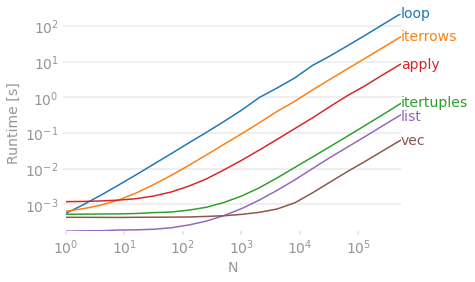

In [40]:
kernels = [
  loop_impl,
  iterrows_impl,
  itertuples_impl,
  apply_impl,
  list_impl,
  vec_impl
]

labels = [str(k.__name__)[:-5] for k in kernels]

perfplot.show(
  setup=lambda n: test_data_sample(n),
  kernels=kernels,
  labels=labels,
  n_range=[2**k for k in range(20)],
  xlabel='N',
  logx=True,
  logy=True,
  #equality_check=None
)